# PROJ-H419 - Biomedical engineering project in image analysis - 202122


# Challenge: Segmentation of Breast Cancer

Student: Yang Liu

Matricule: 473773

Section: INFO

Link to the challenge description:https://www.kaggle.com/aryashah2k/breast-ultrasound-images-dataset

# Dependencies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *

# Data Loader

Definine a frame for image and mask storage

In [2]:
framObjData = {'img' : [],'mask' : []}

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

Split the dataset into trainset and testset, 30 images/masks are taken as the testset

In [3]:
from importlib.resources import path
import os
import shutil
from tabnanny import check
from numpy import number
 

def checkDir(dirpath):
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)
        return False
    return True


def move_file(path, path1,n_of_testfile): # original path, des path, # of files wanted

    file_list = os.listdir(path)
    checkDir(path1)
    for files in file_list:
            filename1 = os.path.split(files)[1]  # read the filename
#             print(filename1)
            full_path = os.path.join(path, files)  # get the filepath and the filename
            for number in range(1,n_of_testfile+1):
                if (filename1 == 'malignant ('+str(number)+')_mask.png' or filename1 == 'malignant ('+str(number)+').png'):  # 根据自己需求更改文件后缀名
                    shutil.move(full_path, path1)  
#                     print(filename1)
            else:
                continue
                
checkDir('Dataset_BUSI_with_GT/malignant_test')
move_file('Dataset_BUSI_with_GT/malignant','Dataset_BUSI_with_GT/malignant_test',30)


Define the train set

In [4]:
framObjTrain = LoadData( framObjData, imgPath = 'Dataset_BUSI_with_GT/malignant'
                        , maskPath = 'Dataset_BUSI_with_GT/malignant'
                         , shape = 256)

Define the test set

In [5]:
framObjTest = LoadData( framObjData, imgPath = 'Dataset_BUSI_with_GT/malignant_test'
                        , maskPath = 'Dataset_BUSI_with_GT/malignant_test'
                         , shape = 256)


Displaying the Ultra Sound Image and corresponding Mask for Cancer:

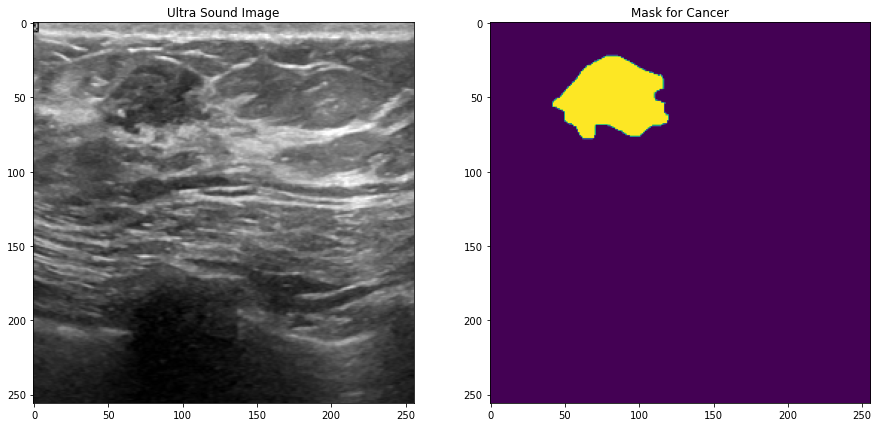

In [14]:
plt.figure(figsize = (15, 15))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

# Unet Model 

In [35]:
def Conv2dBlock(x, nb_filter, kernelSize, strides=(1,1), padding='same'):
    #first convolution
    x = Conv2D(nb_filter, kernelSize, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #second convolution
    x = Conv2D(nb_filter, kernelSize, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


# Now defining Unet 
def Unet(inputImage, numFilters = 16, droupouts = 0.1):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, 2*numFilters, kernelSize = 3)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, 2*numFilters, kernelSize = 3)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, 4*numFilters, kernelSize = 3)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3,8*numFilters, kernelSize = 3)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, 16*numFilters, kernelSize = 3)
    
    # defining decoder path
    u6 = Conv2DTranspose(16*numFilters, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, 8*numFilters, kernelSize = 3)
    
    u7 = Conv2DTranspose(4*numFilters, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = concatenate([u7, c3])
    u7 = Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, 4*numFilters, kernelSize = 3)
    
    u8 = Conv2DTranspose(2*numFilters, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, 2*numFilters, kernelSize = 3)
    
    u9 = Conv2DTranspose(1*numFilters, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9,1*numFilters, kernelSize = 3)
    
    output = Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = Model(inputs = [inputImage], outputs = [output])
    return model

In [36]:
inputs = Input((256, 256, 3))
U_model=Unet(inputs)
U_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 256, 256, 32  128        ['conv2d_76[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 activation_79 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 max_pooling2d_19 (MaxPooling2D  (None, 16, 16, 128)  0          ['activation_79[0][0]']          
 )                                                                                                
                                                                                                  
 dropout_35 (Dropout)           (None, 16, 16, 128)  0           ['max_pooling2d_19[0][0]']       
                                                                                                  
 conv2d_84 (Conv2D)             (None, 16, 16, 256)  295168      ['dropout_35[0][0]']             
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_91 (Conv2D)             (None, 128, 128, 32  9248        ['activation_86[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_87 (BatchN  (None, 128, 128, 32  128        ['conv2d_91[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_87 (Activation)     (None, 128, 128, 32  0           ['batch_normalization_87[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_tr

# Loss Function

In [37]:
#Binary crossentropy
#loss='binary_crossentropy'

In [38]:
import keras.backend as K
# 定义Dice系数
smooth = 1. # 用于防止分母为0
def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return (2 * And + smooth  )/ (K.sum(y_truef) + K.sum(y_predf)+smooth)

# instanctiating model

In [15]:
## instanctiating model
inputs = Input((256, 256, 3))
U_model = Unet(inputs, droupouts= 0.07)
Adam=tf.keras.optimizers.Adam(learning_rate=0.0001)
U_model.compile(optimizer = Adam, loss='binary_crossentropy', metrics = ['Accuracy',dice_coef])
# U_model.compile(optimizer = Adam, loss='binary_crossentropy', metrics = ['Accuracy',keras.tf.keras.metrics.Recall,tf.keras.metrics.Precision])

NameError: name 'Unet' is not defined

In [40]:
from keras.callbacks import ModelCheckpoint

In [41]:
checkp = ModelCheckpoint('./cancer_image_model.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)

# Training 

In [42]:
Train = U_model.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']),validation_split=0.1,epochs = 100,batch_size=8,callbacks = [checkp])

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.7724 - Accuracy: 0.4606 - dice_coef: 0.2386
Epoch 1: val_loss improved from inf to 0.69833, saving model to .\cancer_image_model.h5
24/24 [==============================] - 6s 178ms/step - loss: 0.7724 - Accuracy: 0.4606 - dice_coef: 0.2386 - val_loss: 0.6983 - val_Accuracy: 0.3430 - val_dice_coef: 0.2259
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.6471 - Accuracy: 0.6380 - dice_coef: 0.2367
Epoch 2: val_loss improved from 0.69833 to 0.68092, saving model to .\cancer_image_model.h5
24/24 [==============================] - 4s 163ms/step - loss: 0.6471 - Accuracy: 0.6380 - dice_coef: 0.2367 - val_loss: 0.6809 - val_Accuracy: 0.6358 - val_dice_coef: 0.2252
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.5626 - Accuracy: 0.7973 - dice_coef: 0.2328
Epoch 3: val_loss improved from 0.68092 to 0.65861, saving model to .\cancer_image_model.h5
24/24 [==========================

Epoch 23/100
24/24 [==============================] - ETA: 0s - loss: 0.2853 - Accuracy: 0.9196 - dice_coef: 0.4678
Epoch 23: val_loss did not improve from 0.31005
24/24 [==============================] - 4s 156ms/step - loss: 0.2853 - Accuracy: 0.9196 - dice_coef: 0.4678 - val_loss: 0.3119 - val_Accuracy: 0.9018 - val_dice_coef: 0.3900
Epoch 24/100
24/24 [==============================] - ETA: 0s - loss: 0.2765 - Accuracy: 0.9256 - dice_coef: 0.4670
Epoch 24: val_loss improved from 0.31005 to 0.29710, saving model to .\cancer_image_model.h5
24/24 [==============================] - 4s 165ms/step - loss: 0.2765 - Accuracy: 0.9256 - dice_coef: 0.4670 - val_loss: 0.2971 - val_Accuracy: 0.9030 - val_dice_coef: 0.3804
Epoch 25/100
24/24 [==============================] - ETA: 0s - loss: 0.2647 - Accuracy: 0.9324 - dice_coef: 0.4925
Epoch 25: val_loss improved from 0.29710 to 0.26144, saving model to .\cancer_image_model.h5
24/24 [==============================] - 4s 167ms/step - loss: 0.264

Epoch 70/100
24/24 [==============================] - ETA: 0s - loss: 0.1154 - Accuracy: 0.9765 - dice_coef: 0.7280
Epoch 70: val_loss did not improve from 0.19284
24/24 [==============================] - 4s 156ms/step - loss: 0.1154 - Accuracy: 0.9765 - dice_coef: 0.7280 - val_loss: 0.2210 - val_Accuracy: 0.9358 - val_dice_coef: 0.6333
Epoch 71/100
24/24 [==============================] - ETA: 0s - loss: 0.1172 - Accuracy: 0.9747 - dice_coef: 0.7251
Epoch 71: val_loss did not improve from 0.19284
24/24 [==============================] - 4s 156ms/step - loss: 0.1172 - Accuracy: 0.9747 - dice_coef: 0.7251 - val_loss: 0.2892 - val_Accuracy: 0.9096 - val_dice_coef: 0.6071
Epoch 72/100
24/24 [==============================] - ETA: 0s - loss: 0.1140 - Accuracy: 0.9762 - dice_coef: 0.7327
Epoch 72: val_loss did not improve from 0.19284
24/24 [==============================] - 4s 156ms/step - loss: 0.1140 - Accuracy: 0.9762 - dice_coef: 0.7327 - val_loss: 0.1982 - val_Accuracy: 0.9401 - val_d

Epoch 94/100
24/24 [==============================] - ETA: 0s - loss: 0.0810 - Accuracy: 0.9829 - dice_coef: 0.7930
Epoch 94: val_loss did not improve from 0.17928
24/24 [==============================] - 4s 155ms/step - loss: 0.0810 - Accuracy: 0.9829 - dice_coef: 0.7930 - val_loss: 0.1872 - val_Accuracy: 0.9418 - val_dice_coef: 0.6809
Epoch 95/100
24/24 [==============================] - ETA: 0s - loss: 0.0792 - Accuracy: 0.9835 - dice_coef: 0.7951
Epoch 95: val_loss did not improve from 0.17928
24/24 [==============================] - 4s 160ms/step - loss: 0.0792 - Accuracy: 0.9835 - dice_coef: 0.7951 - val_loss: 0.2111 - val_Accuracy: 0.9326 - val_dice_coef: 0.6667
Epoch 96/100
24/24 [==============================] - ETA: 0s - loss: 0.0808 - Accuracy: 0.9826 - dice_coef: 0.7908
Epoch 96: val_loss did not improve from 0.17928
24/24 [==============================] - 4s 158ms/step - loss: 0.0808 - Accuracy: 0.9826 - dice_coef: 0.7908 - val_loss: 0.1865 - val_Accuracy: 0.9418 - val_d

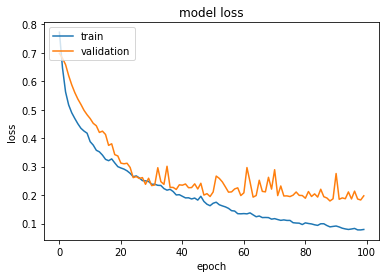

In [43]:
fig = plt.figure()
plt.plot(Train.history['loss'])
plt.plot(Train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('modelloss1.png')

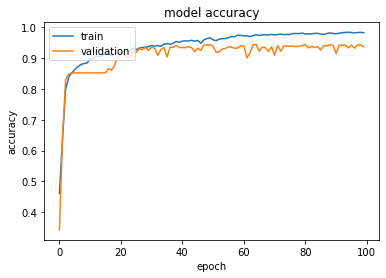

In [44]:
fig = plt.figure()
plt.plot(Train.history['Accuracy'])
plt.plot(Train.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('modelaccuracy1.png')

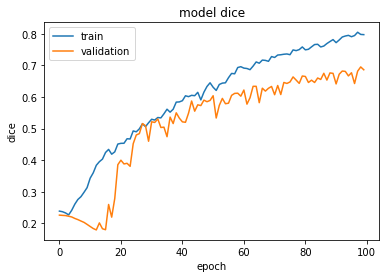

In [45]:
fig = plt.figure()
plt.plot(Train.history['dice_coef'])
plt.plot(Train.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig.savefig('dice1.png')

# Testing

Getting and proccessing data

In [ ]:
def predict (framObjTest,model):
    img = framObjTest['img']
    mask = framObjTest['mask']
    
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  
    return imgProc,predictions, mask

Plot the results

In [17]:
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Ultrasound Image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

Dice coefficient is defined here to evaluate the results

In [18]:
# Dice
smooth = 1. # Avoid denominateur = 0
def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return (2 * And + smooth  )/ (K.sum(y_truef) + K.sum(y_predf)+smooth)


Results:

In [19]:
reals, prediction, masks = predict(framObjTest, U_model)

NameError: name 'predict' is not defined

In [49]:
print(dice_coef((masks[1]),prediction[1][:,:,0]))

tf.Tensor(0.6278535, shape=(), dtype=float32)


In [20]:
num=0
for i in range(30):
    predict_mask=prediction[i][:,:,0]
    predict_mask[predict_mask>0.1]=1            #Process the result with different thresholds to see which one is better
    num+=dice_coef((masks[i]),predict_mask)
print(num)

Plotter(reals[5],predict_mask,masks[5])

NameError: name 'prediction' is not defined

Plot all the results

tf.Tensor(0.9159548, shape=(), dtype=float32)
tf.Tensor(0.64087033, shape=(), dtype=float32)
tf.Tensor(0.57692045, shape=(), dtype=float32)
tf.Tensor(0.79601794, shape=(), dtype=float32)
tf.Tensor(0.8446074, shape=(), dtype=float32)
tf.Tensor(0.8141881, shape=(), dtype=float32)
tf.Tensor(0.81271666, shape=(), dtype=float32)
tf.Tensor(0.8205958, shape=(), dtype=float32)
tf.Tensor(0.7564827, shape=(), dtype=float32)
tf.Tensor(0.67542726, shape=(), dtype=float32)
tf.Tensor(0.66412115, shape=(), dtype=float32)
tf.Tensor(0.558748, shape=(), dtype=float32)
tf.Tensor(0.44094706, shape=(), dtype=float32)
tf.Tensor(0.8410346, shape=(), dtype=float32)
tf.Tensor(0.8875166, shape=(), dtype=float32)


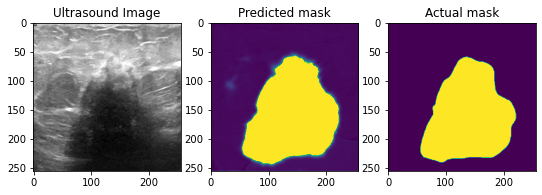

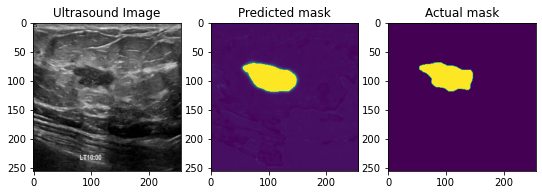

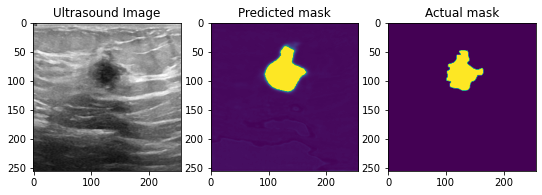

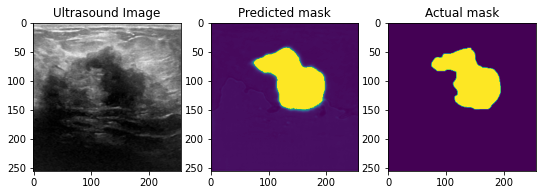

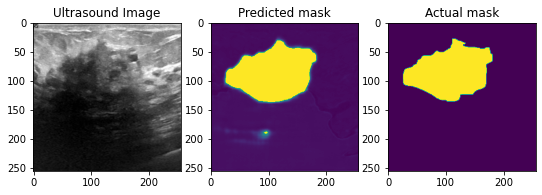

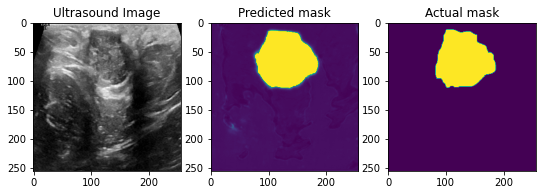

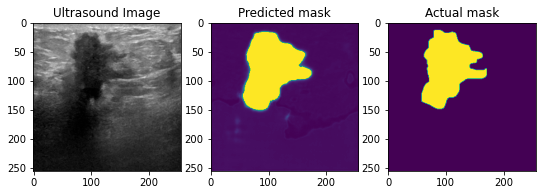

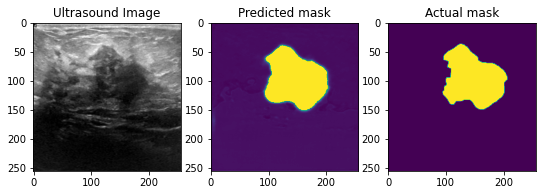

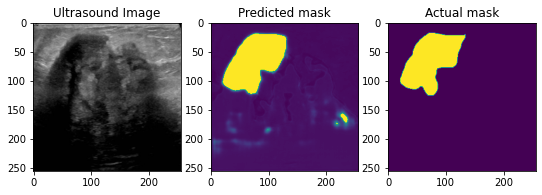

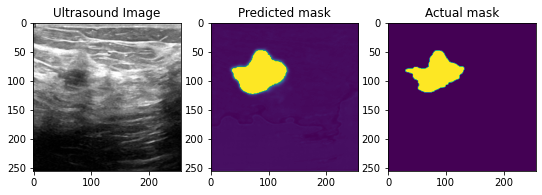

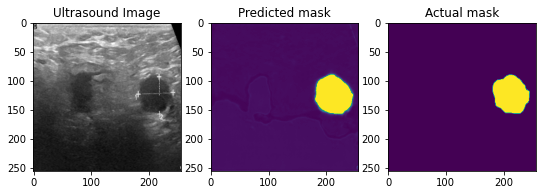

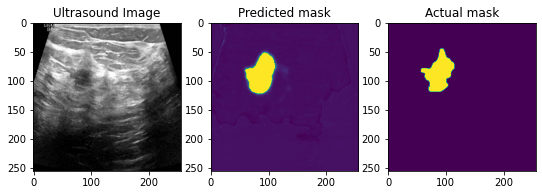

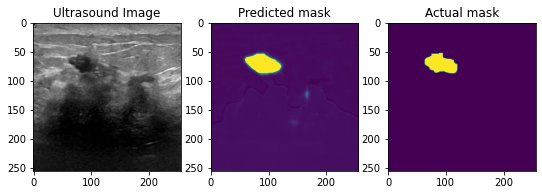

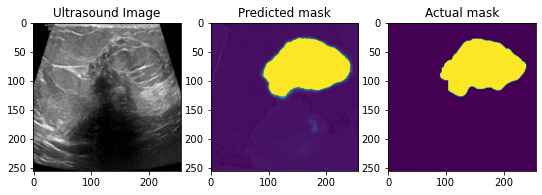

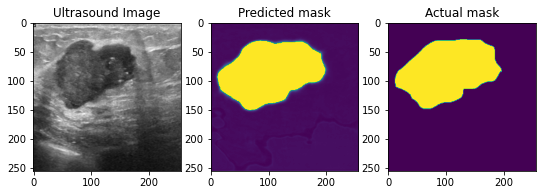

In [64]:
for i in range(15):
    predict_mask=prediction[i][:,:,0]
    Plotter(reals[i],predict_mask, masks[i])
    print(dice_coef((masks[i]),predict_mask))

tf.Tensor(0.80463004, shape=(), dtype=float32)
tf.Tensor(0.75288177, shape=(), dtype=float32)
tf.Tensor(0.799531, shape=(), dtype=float32)
tf.Tensor(0.6551311, shape=(), dtype=float32)
tf.Tensor(0.8492669, shape=(), dtype=float32)
tf.Tensor(0.8604735, shape=(), dtype=float32)
tf.Tensor(0.5561717, shape=(), dtype=float32)
tf.Tensor(0.82408303, shape=(), dtype=float32)
tf.Tensor(0.804202, shape=(), dtype=float32)
tf.Tensor(0.78849167, shape=(), dtype=float32)
tf.Tensor(0.69508415, shape=(), dtype=float32)
tf.Tensor(0.5694021, shape=(), dtype=float32)
tf.Tensor(0.80907196, shape=(), dtype=float32)
tf.Tensor(0.8802728, shape=(), dtype=float32)
tf.Tensor(0.8735024, shape=(), dtype=float32)


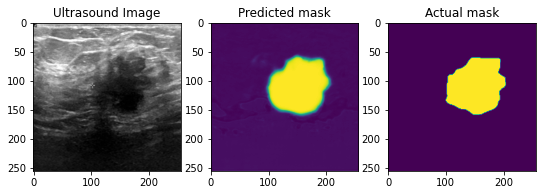

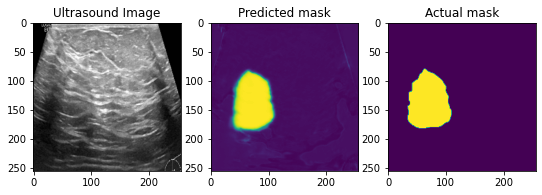

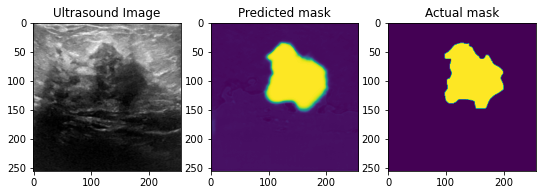

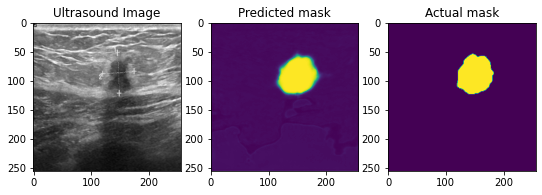

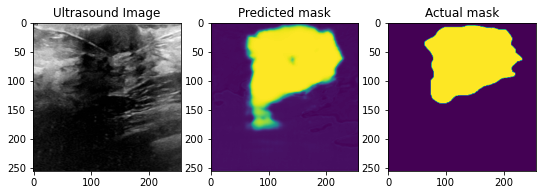

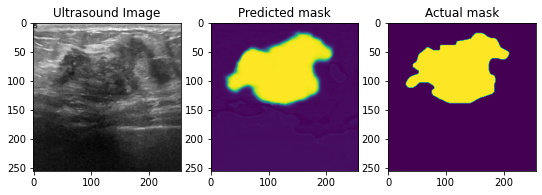

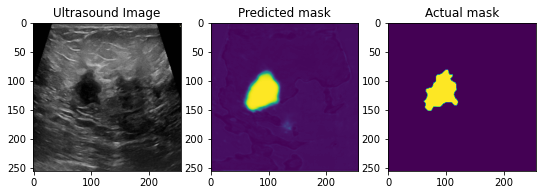

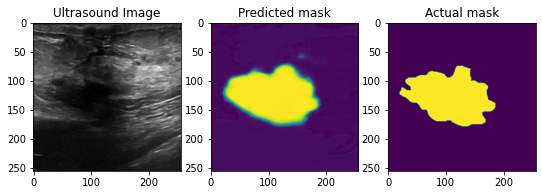

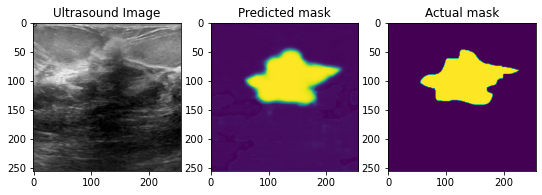

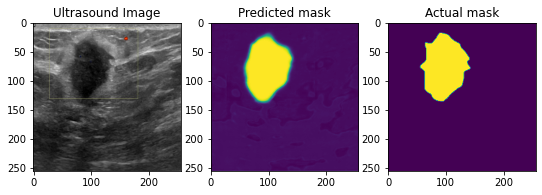

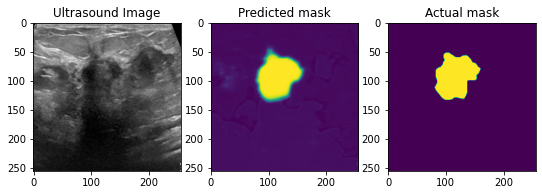

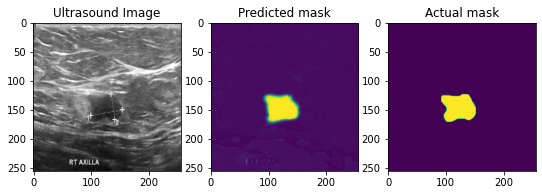

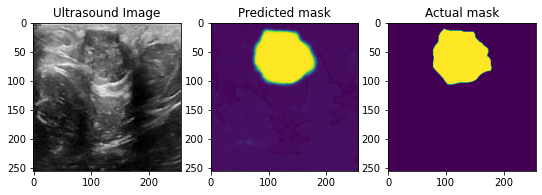

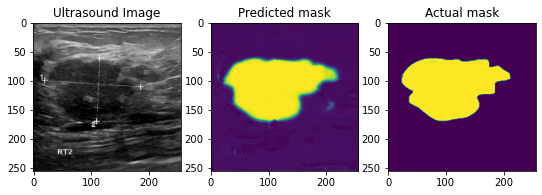

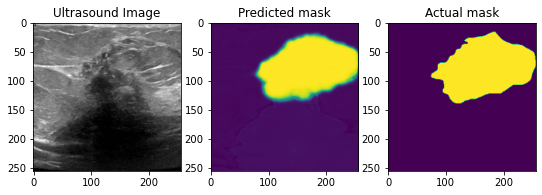

In [56]:
for i in range(15,30):
    Plotter(reals[i],prediction[i][:,:,0], masks[i])
    print(dice_coef((masks[i]),prediction[i][:,:,0]))